# ACE_krill dataset testing image processing methods

## Data description

Data collected during the Antarctic Circumnavigation Expedition (ACE) in 2017 using an EK80 echosounder running at a frequency of 200 kHz.

## Objective

Testing some image processing

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import skimage

In [31]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

## Import data



We import the csv file.

In [3]:
data_path = '/home/benjamin/Documents/datascience/ACE/'
filename = data_path + 'ACE_-D20170207-T104031.sv.csv'
filename = data_path + 'ACE_-D20170210-T184331.sv.csv'

info_df,echogram,depth_data = ACE_box.extract_data(filename)

------------------------------
Data matrix size: (2693, 10171)
Values of depth_start found in the file: {0.09278976}
Values of depth_stop: {499.8584359, 499.3016973}
Values of Sample_count: {2690, 2693}
			The results may be corrupted
Start depth (in meters): 0.09278976
Stop depth (in meters): 499.8584359
Nb of pixels along depth axis: 2693
Depth per pixel (in meters): 0.185579519547
Echogram truncated to the first 100 meters (492 pixels).
-----------------------------


In [4]:
echogram.shape

(492, 10171)

In [5]:
# Contrast stretching
# Get rid of the few largest and smallest values
# and rescale the rest between -1 and 1
p2, p98 = np.percentile(echogram, (2, 98))
data_rescale = skimage.exposure.rescale_intensity(echogram, in_range=(p2, p98))

In [6]:
print(np.min(echogram),np.max(echogram))
print(np.min(data_rescale),np.max(data_rescale))

-134.595696 72.613561
-1.0 1.0


<IPython.core.display.Javascript object>


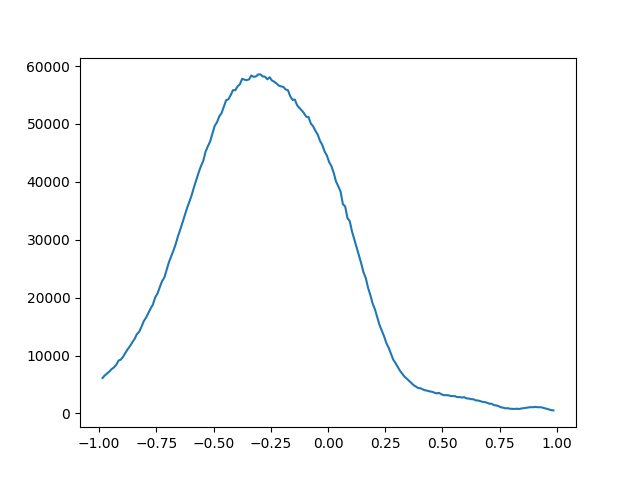

In [7]:
%matplotlib notebook
from skimage.exposure import histogram
h = histogram(data_rescale,nbins=200)
plt.plot(h[1][1:-1],h[0][1:-1])
plt.show()

In [9]:
data_rescale = ACE_box.fix_contrast(echogram)

<IPython.core.display.Javascript object>


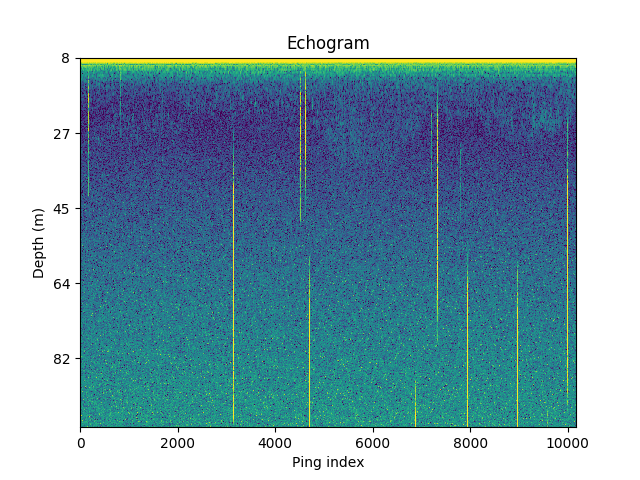

In [10]:
%matplotlib notebook
ACE_box.show_echogram(data_rescale,depth_data)

## Filtering processes

In [11]:
data2 =data_rescale.copy()
#data2[data<-70] = -70
#data2[data>-65] = -65
#data2 = data2 + 70

In [12]:
from skimage.restoration import denoise_wavelet

In [13]:
from skimage.morphology import rectangle
from skimage.filters.rank import median
data3 = median(data2,rectangle(3,3))

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [14]:
def binary_impulse(Sv, threshold=10):
    '''
    :param Sv: gridded Sv values (dB re 1m^-1)
    :type  Sv: numpy.array
    :param threshold: threshold-value (dB re 1m^-1)
    :type  threshold: float
    return:
    :param mask: binary mask (0 - noise; 1 - signal)
    :type  mask: 2D numpy.array
    desc: generate threshold mask    
    '''
    mask = np.ones(Sv.shape).astype(int)
    samples,pings = Sv.shape
    for sample in range(1, samples-1):
        for ping in range(0, pings):
            a = Sv[sample-1, ping]
            b = Sv[sample, ping]
            c = Sv[sample+1, ping]
            if (b - a > threshold) & (b - c > threshold):
                mask[sample, ping] = 0
    return mask

In [15]:
databi = binary_impulse(data2.transpose(), threshold=np.max(data2))
print('Number of noisy pixels: ',databi.size-np.sum(databi))
# Replace the noisy pixels by the minimal value of the image (may not be zero)
databi = databi.transpose()*data2+(1-databi.transpose())*np.min(data2)

Number of noisy pixels:  27770


In [16]:
## Improve the interference rejection
grad = np.gradient(data2,axis=1)
grad2 = np.gradient(np.roll(data2,1,axis=1),axis=1)

In [17]:
datar = np.roll(data2,1,axis=1)
datal = np.roll(data2,-1,axis=1)
grad = data2 - datar + data2 - datal

In [18]:
print('Gradients',np.max(grad),np.min(grad))

Gradients 4.0 -3.53935370978


In [19]:
np.min(data2)

-1.0

In [20]:
mask = grad.copy()
mask[grad>np.max(grad)/10]=1
mask[grad<=np.max(grad)/10]=0

In [21]:
data_dd = data2.copy()
data_dd[mask==1] = (datar[mask==1] + datal[mask==1]) / 2

<IPython.core.display.Javascript object>


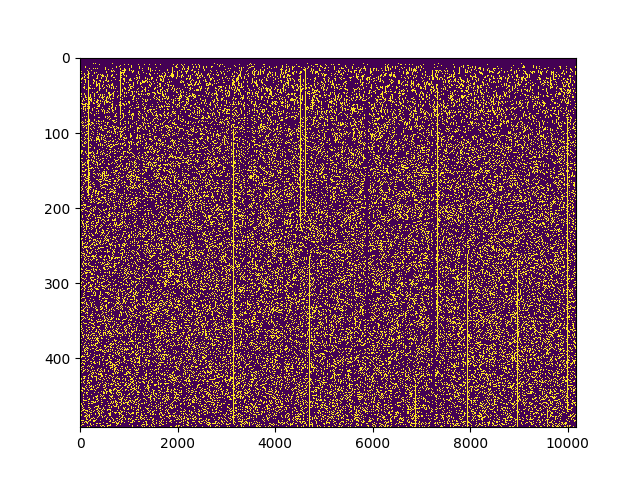

In [22]:
plt.figure()

#plt.imshow(data2, aspect='auto')
plt.imshow(mask, aspect='auto')

### From the box

In [32]:
data_clean = ACE_box.remove_vertical_lines(data2)

Number of noisy pixels removed:  1097520.0


In [23]:
data3 = databi - np.mean(databi,1,keepdims=True)

In [24]:
datafilt = denoise_wavelet(data3, sigma=0.3)
#datafilt2 = sp.signal.medfilt(data3,kernel_size=3)

In [25]:
from skimage.filters import gaussian
gauss_denoised = gaussian(data3,5)

In [26]:
gauss_denoised2 = gaussian(datafilt,5)

### Visualisation of the results of the first filtering processes

<IPython.core.display.Javascript object>


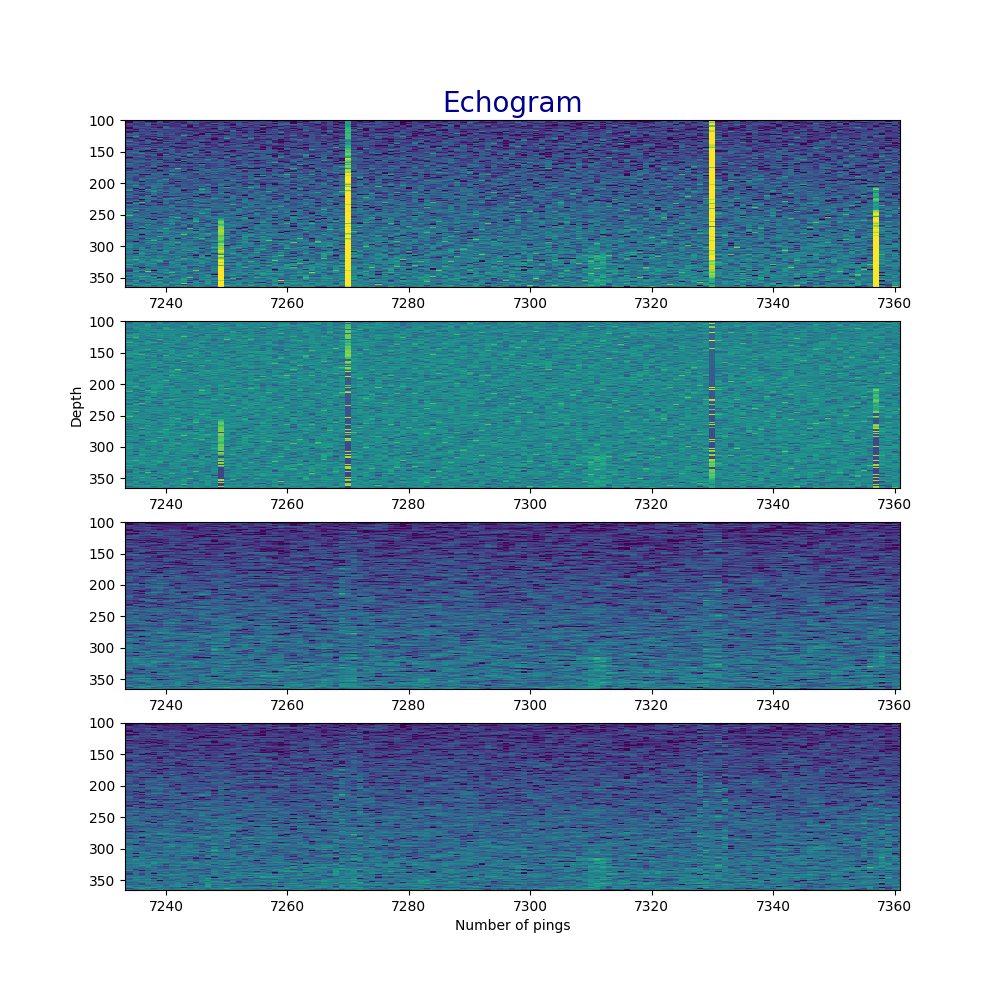

In [33]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(4,1,1)
ax1.imshow(data2[0:,:],aspect='auto')

plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(4,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(data3[0:,:],aspect='auto')

plt.ylabel('Depth')
ax3 = plt.subplot(4,1,3, sharex=ax1, sharey=ax1)
#ax3.imshow(gauss_denoised[0:,:],aspect='auto')
ax3.imshow(data_dd[0:,:],aspect='auto')
#ax3.imshow(databi[0:,:],aspect='auto')

ax4 = plt.subplot(4,1,4, sharex=ax1, sharey=ax1)
#ax4.imshow(data_dd[0:,:],aspect='auto')
ax4.imshow(data_clean[0:,:],aspect='auto')
#ax4.imshow(gauss_denoised2[0:,:],aspect='auto')
plt.xlabel('Number of pings')
plt.show()

We then try to get rid of the remaining background noise by substracting the mean of each line line to every pixel (smoothing).

### Detecting the Krill swarms

In [35]:
signaldata = gauss_denoised[0:,:]
energy = np.sqrt(np.sum(signaldata**2,0))
normalized_energy = (energy-np.mean(energy))/np.std(energy)

In [40]:
binary_signal = normalized_energy.copy()
threshold = 0.5
binary_signal[binary_signal<threshold] = 0
binary_signal[binary_signal>threshold] = 100

<IPython.core.display.Javascript object>


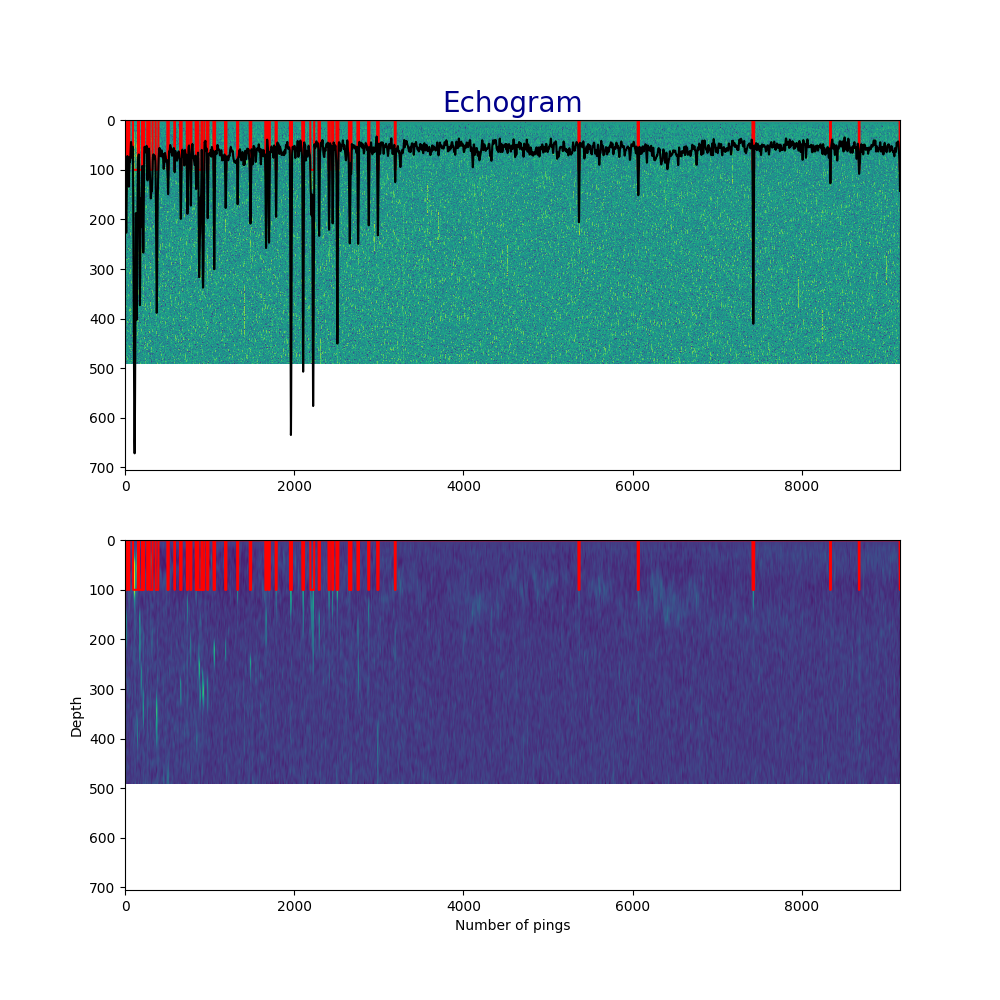

In [41]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(data3[0:,:],aspect='auto')
ax1.plot(binary_signal,color='r')
ax1.plot(energy*100,color='k')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(signaldata,aspect='auto')
plt.ylabel('Depth')
ax2.plot(binary_signal,color='r')
plt.xlabel('Number of pings')
plt.show()

In [42]:
# In the toolbox:
binary_signal2,energy_fluctuation = ACE_box.krill_function(gauss_denoised)

<IPython.core.display.Javascript object>


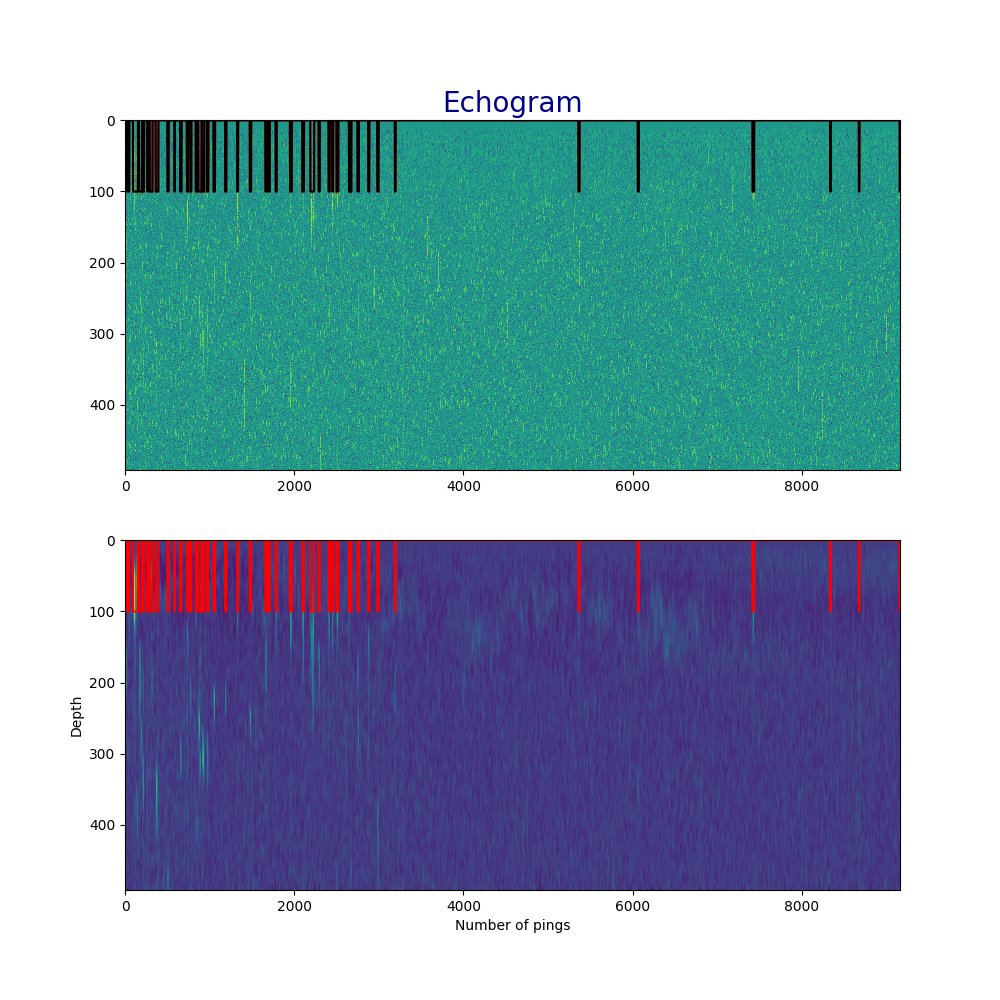

In [43]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(data3[0:,:],aspect='auto')
ax1.plot(binary_signal,color='r')
ax1.plot(binary_signal2,color='k')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(signaldata,aspect='auto')
plt.ylabel('Depth')
ax2.plot(binary_signal,color='r')
plt.xlabel('Number of pings')
plt.show()